# Music Segmentation
- 원본 사운드는 정보(다변수)를 제공하는 표현으로 변환
- DP을 이용해, 평균 이동을 새로운 표현(변환된 데이터)에서 감지

### Tempogram
템포 정보의 중간 수준 표현  
오디오 신호의 템포 변화와 로컬 펄스를 특성화하도록 구성  
템포 정보를 오디오 분할에 통합하는 것에 유리한 접근

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display

import ruptures as rpt

c:\Users\spec3\anaconda3\envs\dgdg\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# utility func.
def fig_ax(figsize=(15, 5), dpi=150):
    return plt.subplots(figsize=figsize, dpi=dpi)

### Load Data
`Librosa`의 샘플 데이터 (Dance of the Sugar Plum Fairy from The Nutcracker by Tchaikovsky)

In [3]:
duration = 30 # 30초
signal, sr = librosa.load(librosa.ex("nutcracker"), duration=duration)

# 음원 재생
display(Audio(data=signal, rate=sr))

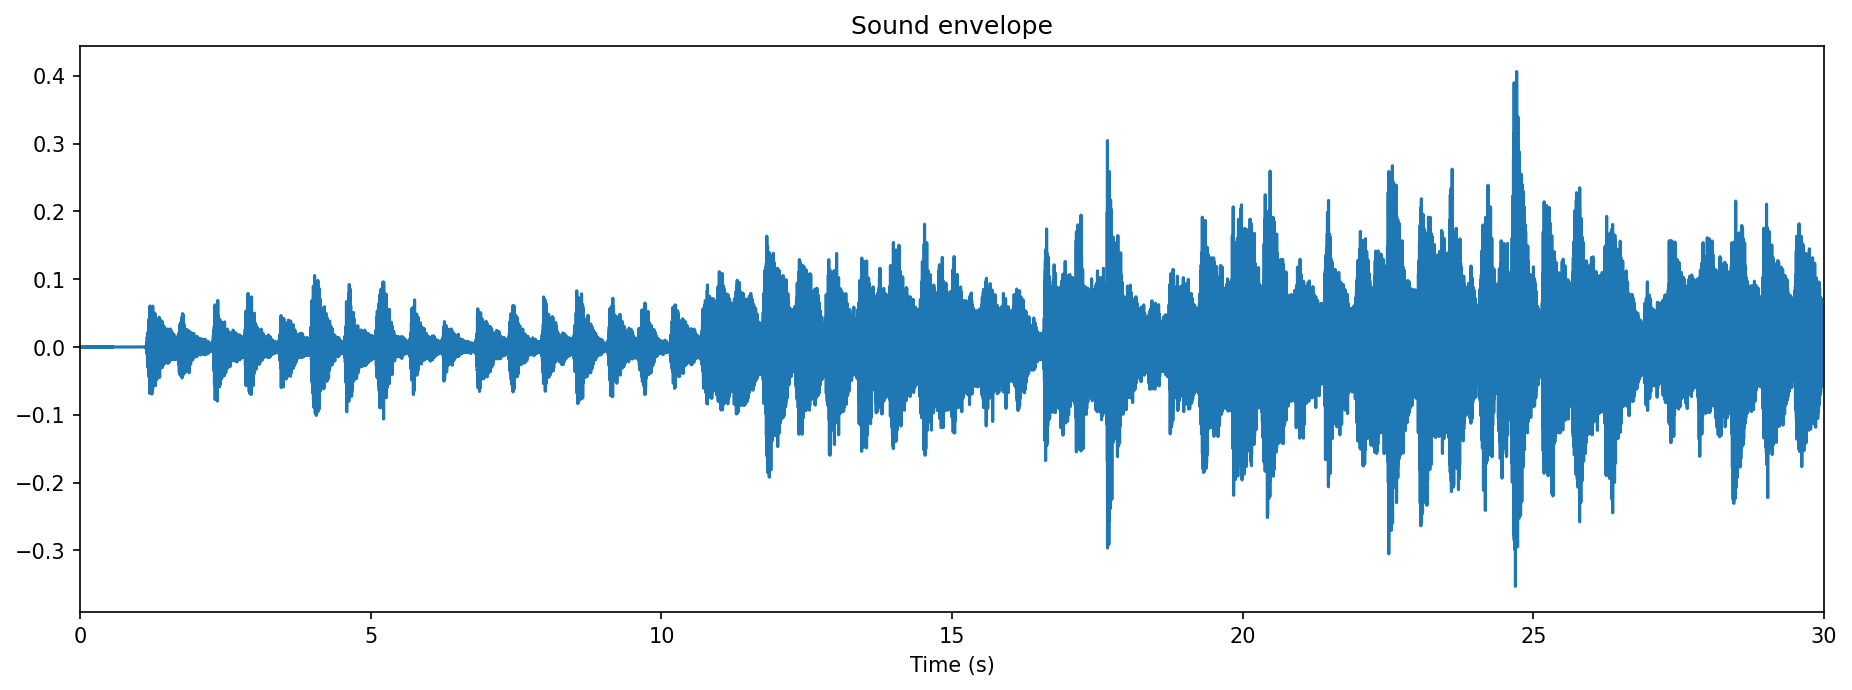

In [4]:
fig, ax = fig_ax()
ax.plot(np.arange(signal.size)/sr, signal)
ax.set_xlim(0, signal.size/sr)
ax.set_xlabel("Time (s)")
_ = ax.set(title="Sound envelope")

### Signal Segmentation
#### Tempogram 변환
템포그램은 시간축을 따라 템포(BPM) 프로파일을 측정

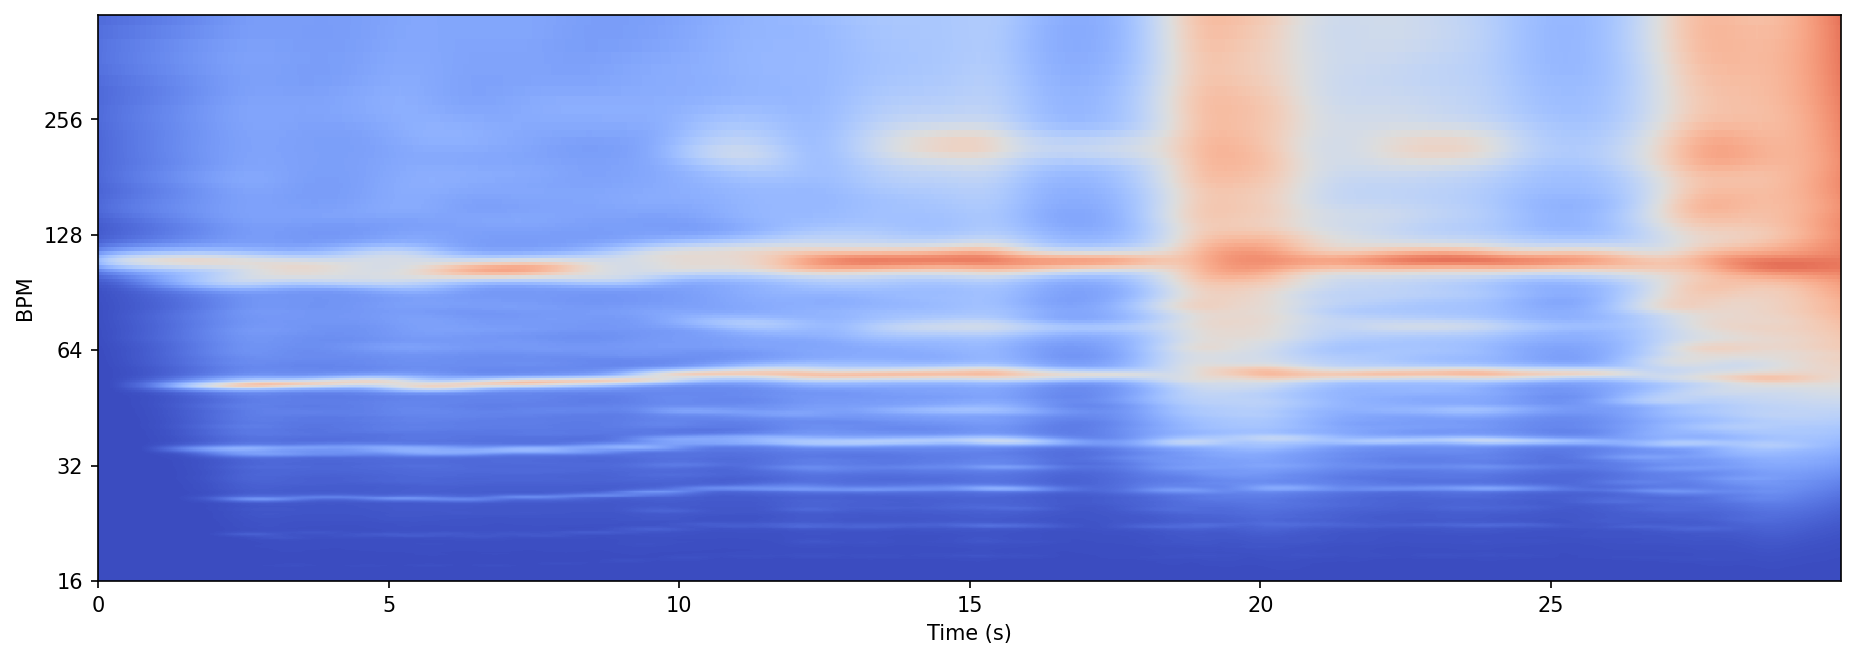

In [5]:
# 강도 계산
hop_length_tempo = 256
oenv = librosa.onset.onset_strength(
    y = signal,
    sr = sr,
    hop_length = hop_length_tempo
)
# 템포그램 계산
tempogram = librosa.feature.tempogram(
    onset_envelope = oenv,
    sr = sr,
    hop_length = hop_length_tempo
)
# 템포그램 출력
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax = ax,
    hop_length=hop_length_tempo,
    sr = sr,
    x_axis = "s",
    y_axis= "tempo"
)

#### Detection Algorithm
다변량 신호인 템포그램의 평균 변화를 감지하도록 선택 -> L2 비용 함수를 사용하는 것과 같음  
```python
rpt.Dynp(model="l2") # 방법 1
rpt.KernelCPD(kernel="linear") # 방법 2 이건 사라진듯
```  
후자의 경우 C로 구현되어 속도가 더 빠름  


변경점의 수를 측정하기 위해 엘보우 방식(elbow method) 사용  
엘보우 너머의 변경 지점을 추가하면 비용 합계가 약간만 감소함

```python
algo = rpt.KernelCPD(kernel="linear").fit(signal)
algo.cost.sum_of_costs(bkps)
```

In [10]:
algo = rpt.Dynp(model="l2").fit(tempogram.T)

In [11]:
# 변경점 설정
n_bkps_max = 20

In [12]:
_ = algo.predict(n_bkps=n_bkps_max)

In [13]:
array_of_n_bkps = np.arange(1, n_bkps_max+1)

In [16]:
def get_sum_of_cost(algo, n_bkps)->float:
    # 변경된 점들의 비용 합계 반환
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

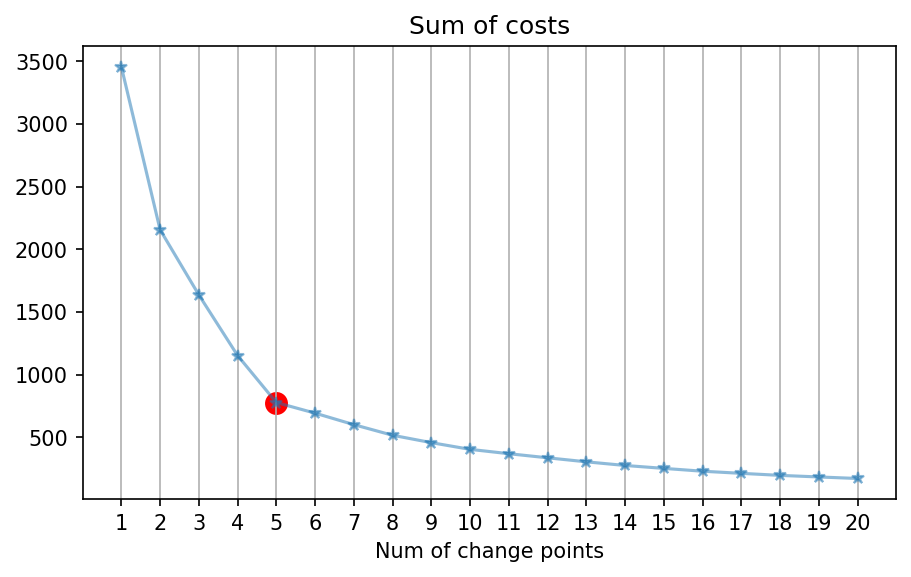

In [17]:
fig, ax = fig_ax((7, 4))
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha = 0.5
)
ax.set_xticks(array_of_n_bkps)
ax.set_xlabel("Num of change points")
ax.set_title("Sum of costs")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max+1)
# higliht n_bkps=5
_ = ax.scatter([5], [get_sum_of_cost(algo=algo, n_bkps=5)], color="r", s=100)

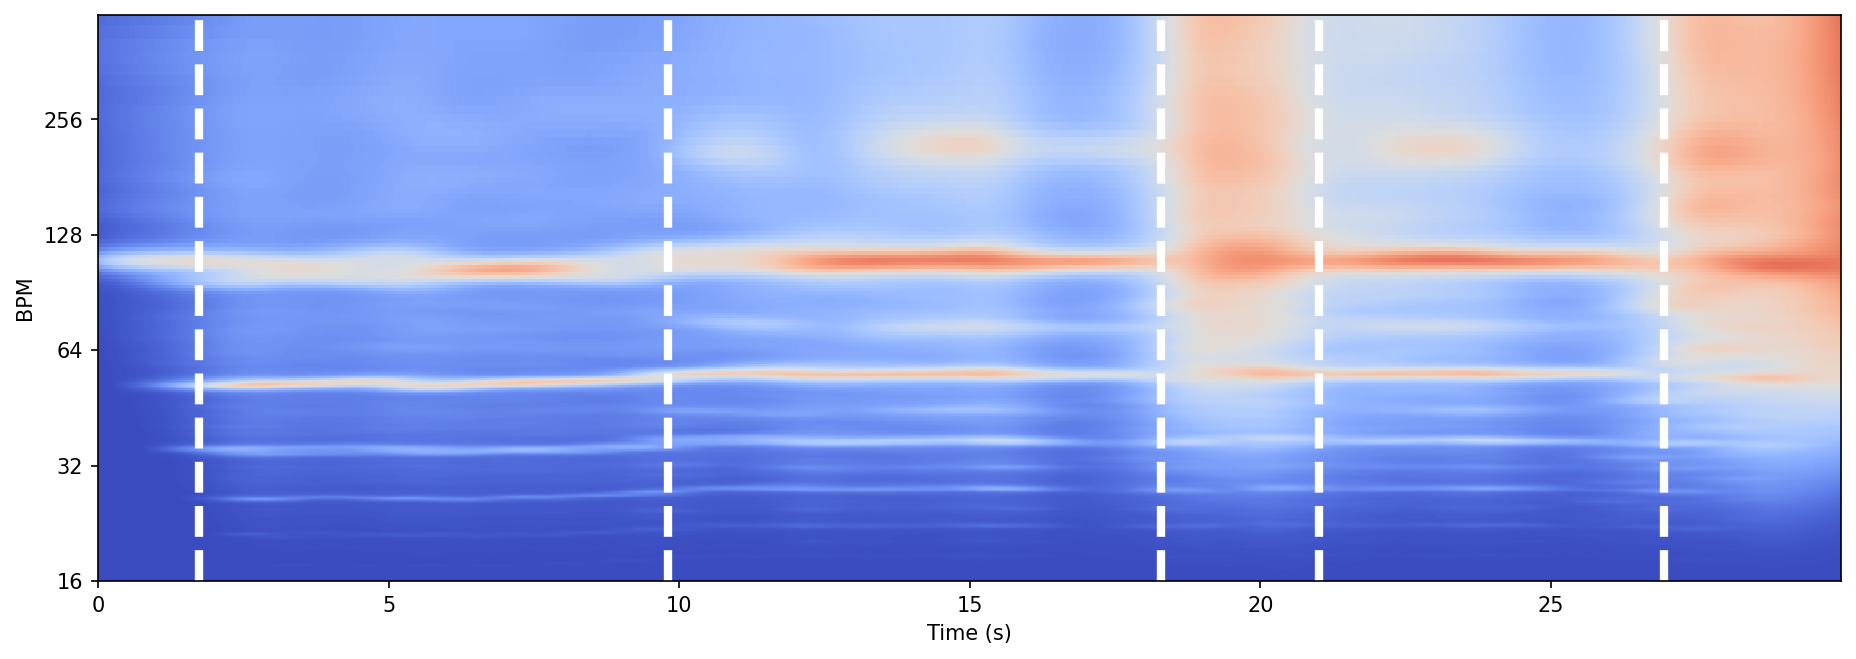

In [19]:
# segmentation
n_bkps = 5
bkps = algo.predict(n_bkps=n_bkps)
# 예상 변경점(프레임 수)을 실제 타임스탬프로 변환
bkps_times = librosa.frames_to_time(bkps, sr=sr, hop_length=hop_length_tempo)

# display result
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax = ax,
    x_axis = "s",
    y_axis = "tempo",
    hop_length = hop_length_tempo,
    sr = sr
)
# 타임스탬프
for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

시각적으로, 추정된 변환점은 비교적 일정한 속도 프로파일로 신호의 일부를 분리  
변화점에 의해 정의된 개별 세그먼트를 들음으로써 검증 가능

In [20]:
# 원래 신호의 인덱스에 해당하는 변화점을 계산
bkps_time_indexes = (sr * bkps_times).astype(int).tolist()

for (segment_number, (start, end)) in enumerate(rpt.utils.pairwise([0] + bkps_time_indexes), start=1):
    segment = signal[start:end]
    print(f"Segment n*{segment_number} (duration: {segment.size/sr:.2f}")
    display(Audio(data=segment, rate=sr))

Segment n*1 (duration: 1.74


Segment n*2 (duration: 8.07


Segment n*3 (duration: 8.48


Segment n*4 (duration: 2.73


Segment n*5 (duration: 5.92


Segment n*6 (duration: 3.06
